## Task 4

In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import numpy as np
import pandas as pd 
import torch.nn as nn
import torch.nn.functional as F

#Remove all the warnings 
import warnings
warnings.filterwarnings('ignore')

#set Cuda launch blocking = 1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Retina display
%config InlineBackend.figure_format = 'retina'
try: 
    from einops import rearrange 
except:
    %pip install einops
    from einops import rearrange 


In [2]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


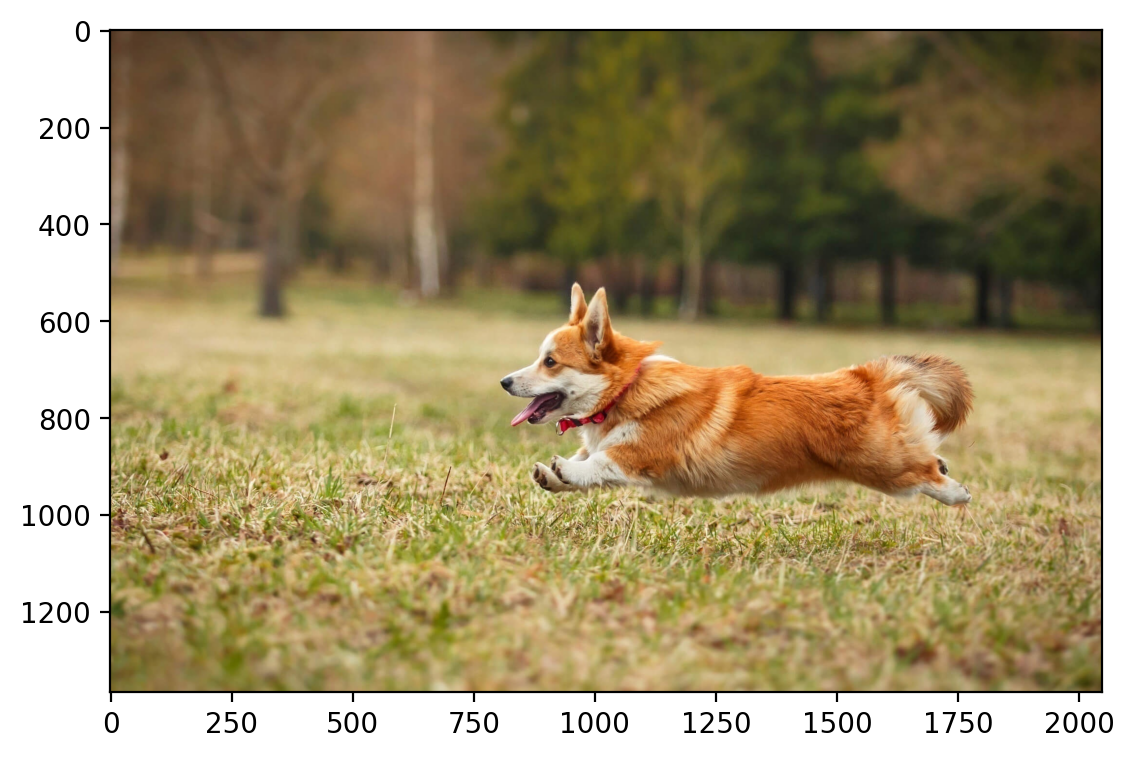

In [3]:
plt.imshow(rearrange(img,'c h w ->h w c'))

In [4]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

scaler_img = MinMaxScaler().fit(img.reshape(-1,1))
scaler_img

MinMaxScaler()

In [5]:
img_scaled = scaler_img.transform(img.reshape(-1,1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)

(3, 1365, 2048)


In [6]:
img_scaled = img_scaled.to(device)
img_scaled 

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2980, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2980, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2980, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3843, 0.3843],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3882, 0.3843],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3882, 0.3882]],

        [[0.2000, 0.2039, 0.2039,  ..., 0.2157, 0.2118, 0.2118],
         [0.2000, 0.2039, 0.2039,  ..., 0.2157, 0.2118, 0.2118],
         [0.2000, 0.2039, 0.2078,  ..., 0.2157, 0.2118, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4118,  ..., 0.3216, 0.3137, 0.3137],
         [0.4039, 0.4039, 0.4118,  ..., 0.3216, 0.3176, 0.3137],
         [0.4039, 0.4039, 0.4118,  ..., 0.3255, 0.3176, 0.3176]],

        [[0.1451, 0.1490, 0.1490,  ..., 0.1176, 0.1176, 0.1176],
         [0.1451, 0.1490, 0.1490,  ..., 0.1176, 0.1176, 0.1176],
         [0.1451, 0.1490, 0.1412,  ..., 0.1176, 0.1176, 0.

In [7]:
crop = transforms.functional.crop(img_scaled.cpu(),700,800,150,150)
crop.shape

torch.Size([3, 150, 150])

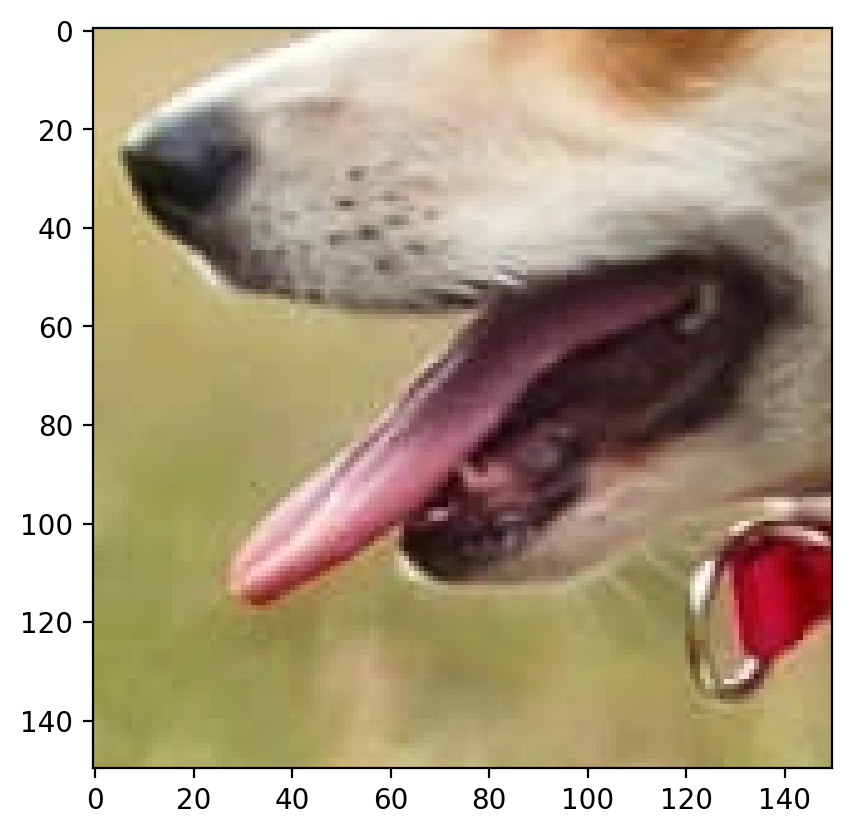

In [8]:
plt.imshow(rearrange(crop,'c h w -> h w c'))

In [9]:
crop = crop.to(device)

In [10]:
channel,height,width = crop.shape
print(channel,height,width)

3 150 150


#### <i>Q.1 Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank r. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics.</i>

### <i>Matrix Factorization</i>

In [11]:
def factorize(A,rank=50,itr=1000,device = torch.device("cpu")):

    A = A.to(device)
    channel,height,width = A.shape
    W_s = []
    H_s = []

    mask = ~torch.isnan(A[0])
    for i in range(channel):
        W = torch.randn(height,rank, requires_grad = True, device = device)
        H = torch.randn(rank,width, requires_grad = True, device = device)
        W_s.append(W)
        H_s.append(H)
    
    optimizer = torch.optim.Adam(W_s + H_s, lr = 0.01)
    for i in range(itr):
        losses = []
        for c in range(channel):
            diff_matrix = torch.mm(W_s[c],H_s[c]) - A[c,:,:]
            diff_vector = diff_matrix[mask]
            loss = torch.norm(diff_vector)
            losses.append(loss)

        loss = sum(losses)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if i%1000 == 0:
            print(f"Itr {i}: loss - {loss.item()}")

        if i == itr-1:
            print(f"loss - {loss}")
            
    return W_s,H_s

In [12]:
def cat_channels(W,H,channel):
    channels = []

    for c in range(channel):
        temp = torch.mm(W[c],H[c])
        channels.append(temp)
    reconstructed_img = torch.stack(channels,dim=0)
    reconstructed_img = rearrange(reconstructed_img,'c h w -> h w c')

    return reconstructed_img

In [13]:
def calculate_rmse(original_image,reconstructed_img):
    return torch.sqrt(torch.mean(original_image - reconstructed_img)**2)

def calculate_psnr(original_image, reconstructed_img):
    error = (torch.mean(original_image - reconstructed_img)**2).detach().numpy()
    i_max = (torch.max(original_image)).detach().numpy()

    return(20*np.log10(i_max) - 10*np.log10(error))

In [14]:
def plot_images(original_img,reconstructed_img, title=""):

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(reconstructed_img.detach().cpu().numpy())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [15]:
rank = 50
W,H = factorize(crop,rank,10000)

Itr 0: loss - 3179.894658411179
Itr 1000: loss - 13.716156333390796
Itr 2000: loss - 10.487133931414403
Itr 3000: loss - 9.073635105380077
Itr 4000: loss - 8.180784093134921
Itr 5000: loss - 7.554736709118443
Itr 6000: loss - 7.098515948279557
Itr 7000: loss - 6.708845460413281
Itr 8000: loss - 6.415715726246498
Itr 9000: loss - 6.152306530099197
loss - 5.913306741309328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 3.221361757985256e-05
PSNR: 89.83921002596088 db


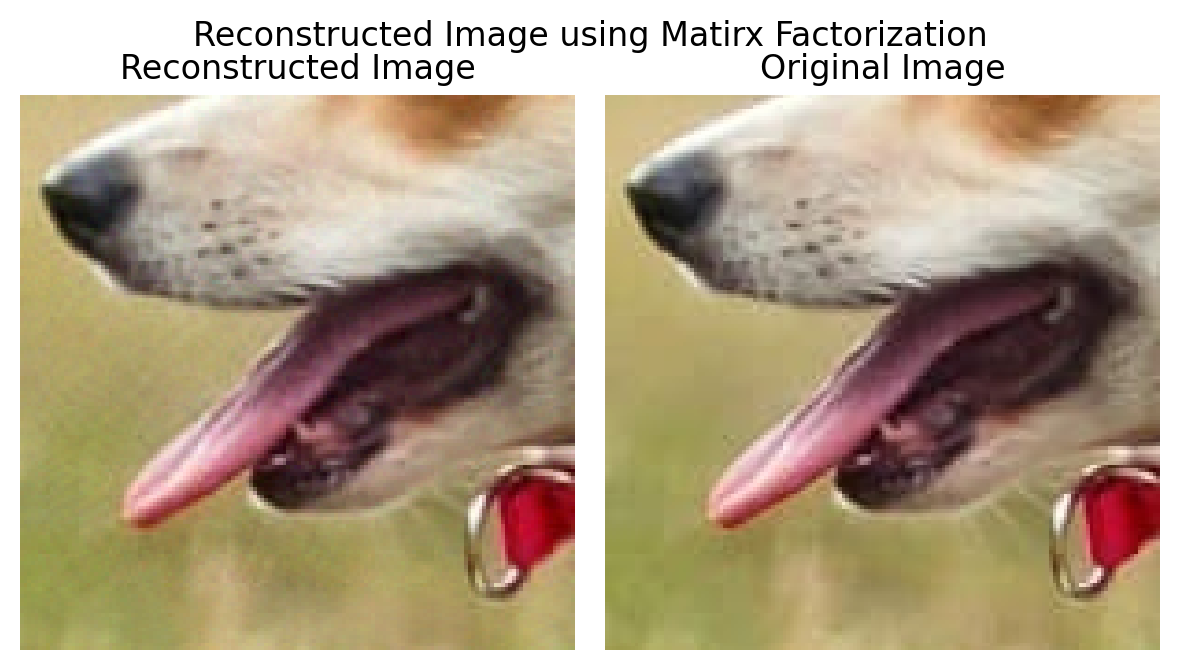

In [16]:
reconstructed_img = cat_channels(W,H,channel)
print(f"RMSE: {calculate_rmse(rearrange(crop,'c h w -> h w c'),reconstructed_img)}")
print(f"PSNR: {calculate_psnr(rearrange(crop,'c h w -> h w c'),reconstructed_img)} db")
plot_images(crop,reconstructed_img,"Reconstructed Image using Matirx Factorization")

#### <i>Q.2 Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.</i>

### <i>Matrix Factorization<i>

In [17]:
def patch_image(image,patch_size):
    temp = image.clone()

    channel,height,width = temp.shape
    x = np.random.randint(width-patch_size+1)
    y = np.random.randint(height-patch_size+1)
    # temp[:,y:y+patch_size,x:x+patch_size] = 1
    temp[:,y:y+patch_size,x:x+patch_size] = float('nan')
    print(x,y)
    
    return temp

66 37


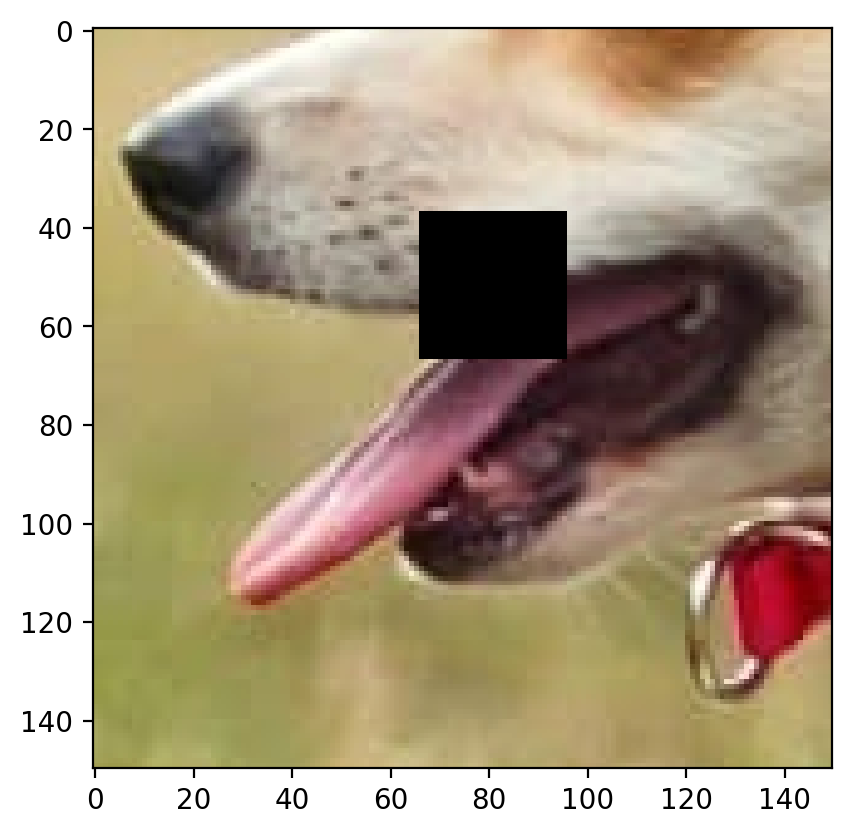

In [18]:
patch_size = 30
patch_img = patch_image(crop,patch_size)
plt.imshow(rearrange(patch_img,'c h w -> h w c'))

In [19]:
pixel = []
for i in range(150):
    for j in range(150):
        k = False
        rgb = []
        for c in range(3):
            if (str(patch_img[c,i,j].item()) != 'nan'):
                k = True
                rgb.append(c)
        if k:
            pixel.append(rgb)
        

In [20]:
patch_img[pixel].shape

torch.Size([21600, 3, 150, 150])

In [21]:
rank = 50
W,H = factorize(patch_img,rank,10000)

Itr 0: loss - 3172.586424925714
Itr 1000: loss - 12.619536584489548
Itr 2000: loss - 9.839180583311093
Itr 3000: loss - 8.492394426824859
Itr 4000: loss - 7.663688510387479
Itr 5000: loss - 7.053522613824794
Itr 6000: loss - 6.622987062786754
Itr 7000: loss - 6.240343521948667
Itr 8000: loss - 5.941023250152105
Itr 9000: loss - 5.6824654854447765
loss - 5.4590056037765775


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.0012255830715417683
PSNR: 58.23314492790389 db


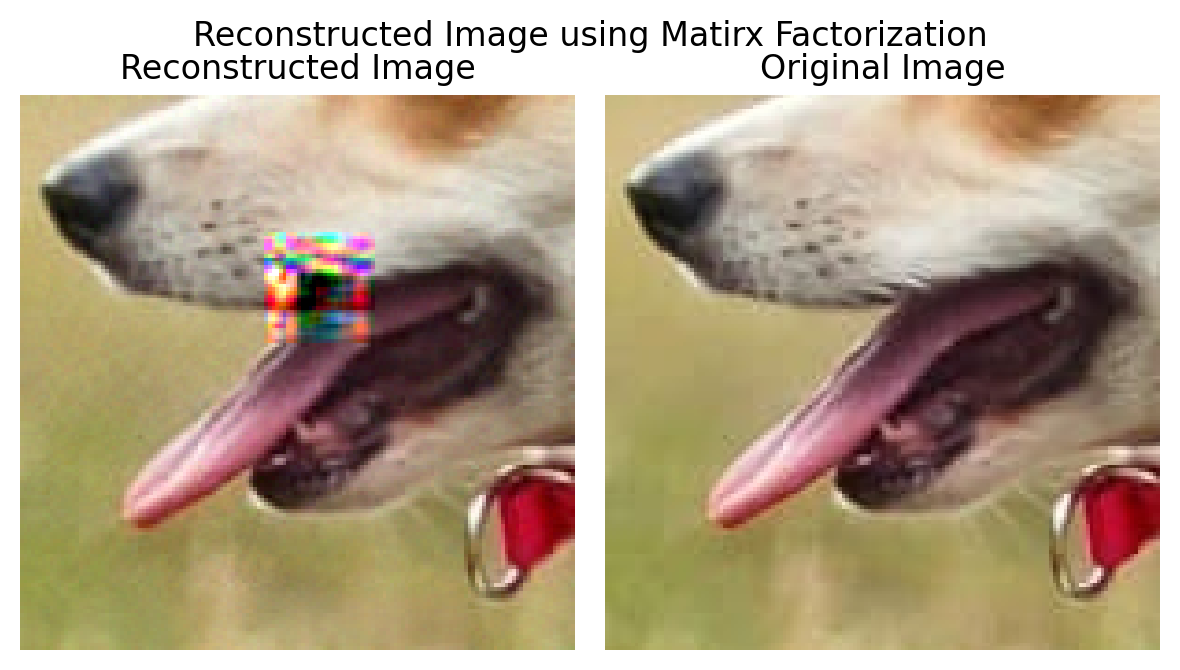

In [22]:
reconstructed_img = cat_channels(W,H,channel)
patch_img_rmse_MF = calculate_rmse(rearrange(crop,'c h w -> h w c'),reconstructed_img)
patch_img_psnr_MF = calculate_psnr(rearrange(crop,'c h w -> h w c'),reconstructed_img)
print(f"RMSE: {patch_img_rmse_MF}")
print(f"PSNR: {patch_img_psnr_MF} db")
plot_images(crop,reconstructed_img,"Reconstructed Image using Matirx Factorization")

### <i>RFF + Linaer Regression</i>

In [23]:
def coordinate_mapping(img):
    
    c,height,width = img.shape 
    w_coords = torch.arange(width).repeat(height,1)
    h_coords = torch.arange(height).repeat(width,1).T
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords,w_coords],dim=1).float().to(device)

    Y = rearrange(img,'c h w -> (h w) c').float().to(device)
    return X,Y

In [24]:
# Removing 'nan's from the Dataset.
def removve_nans(X,Y,features):
    df_X = pd.DataFrame(X)
    df_Y = pd.DataFrame(Y)
    df = pd.concat((df_X,df_Y), axis = 1)

    df = df.dropna()
    new_X =np.array(df.iloc[:,:features])
    new_Y = np.array(df.iloc[:,features:])
    new_X = torch.tensor(new_X)
    new_Y = torch.tensor(new_Y)
    return new_X,new_Y

In [25]:
X,Y = coordinate_mapping(patch_img)
print(f"X:{X.shape} Y: {Y.shape}")
print("X :",X)

print("Y :",Y)

X:torch.Size([22500, 2]) Y: torch.Size([22500, 3])
X : tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [149., 147.],
        [149., 148.],
        [149., 149.]])
Y : tensor([[0.7882, 0.7216, 0.5020],
        [0.7882, 0.7294, 0.5059],
        [0.7882, 0.7294, 0.5059],
        ...,
        [0.6706, 0.6667, 0.4118],
        [0.6627, 0.6588, 0.4039],
        [0.6549, 0.6510, 0.3882]])


In [26]:
scaler_X = MinMaxScaler(feature_range=(-1,1)).fit(X.cpu())

scaled_X = scaler_X.transform(X.cpu())

scaled_X = torch.tensor(scaled_X).float().to(device)

In [27]:
new_X,new_Y = removve_nans(scaled_X,Y,2)

In [28]:
print("Dataset size with 'nan' values:")
print(f"X: {scaled_X.shape}\nY: {Y.shape}\n")
print("Datset size after Removing 'nan' values:")
print(f"X: {new_X.shape}\nY: {new_Y.shape}")

Dataset size with 'nan' values:
X: torch.Size([22500, 2])
Y: torch.Size([22500, 3])

Datset size after Removing 'nan' values:
X: torch.Size([21600, 2])
Y: torch.Size([21600, 3])


In [29]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [30]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [31]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [32]:
train(net, 0.01, new_X, new_Y, 1000)

Epoch 0 loss: 1.016463
Epoch 100 loss: 0.087638
Epoch 200 loss: 0.035349
Epoch 300 loss: 0.034180
Epoch 400 loss: 0.034174
Epoch 500 loss: 0.034174
Epoch 600 loss: 0.034174
Epoch 700 loss: 0.034174
Epoch 800 loss: 0.034174
Epoch 900 loss: 0.034174


0.03417430445551872

In [33]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):

    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        predict = net(X)
        predict = predict.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    
    rmse = calculate_rmse(rearrange(original_img,'c h w -> h w c'),predict)
    psnr = calculate_psnr(rearrange(original_img,'c h w -> h w c'),predict)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(predict.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return rmse,psnr

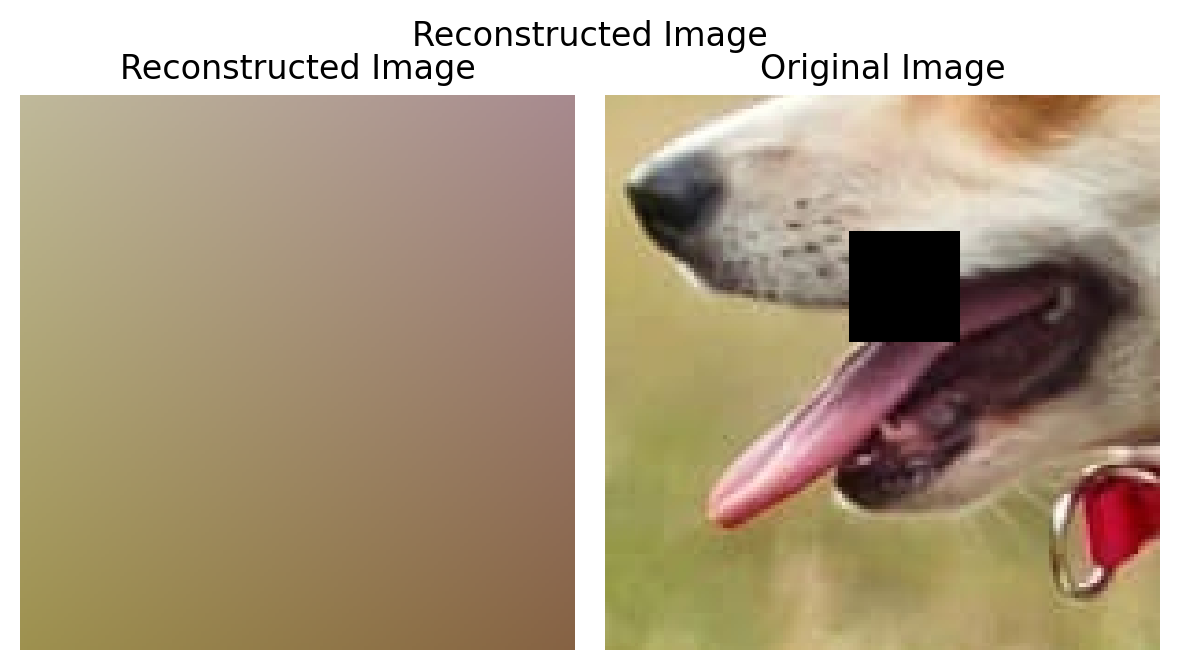

In [34]:
_,_ = plot_reconstructed_and_original_image(patch_img, net, scaled_X, title="Reconstructed Image")

In [35]:
def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int
    
    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)

In [36]:
scaled_X_poly = poly_features(scaled_X, 50)

In [37]:
scaled_X_poly.dtype, scaled_X_poly.shape, Y.shape, Y.dtype

(torch.float32,
 torch.Size([22500, 1326]),
 torch.Size([22500, 3]),
 torch.float32)

In [38]:
features = scaled_X_poly.shape[1]
features 

1326

In [39]:
scaled_new_X_poly,scaled_new_Y_poly = removve_nans(scaled_X_poly,Y,features)

In [40]:
net = LinearModel(scaled_new_X_poly.shape[1], 3)
net.to(device)

train(net, 0.005, scaled_new_X_poly, scaled_new_Y_poly, 1500)

Epoch 0 loss: 0.340482
Epoch 100 loss: 0.022694
Epoch 200 loss: 0.018719
Epoch 300 loss: 0.017190
Epoch 400 loss: 0.016182
Epoch 500 loss: 0.015413
Epoch 600 loss: 0.014798
Epoch 700 loss: 0.014293
Epoch 800 loss: 0.013868
Epoch 900 loss: 0.013508
Epoch 1000 loss: 0.013202
Epoch 1100 loss: 0.012934
Epoch 1200 loss: 0.012699
Epoch 1300 loss: 0.012505
Epoch 1400 loss: 0.012310


0.012170525267720222

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


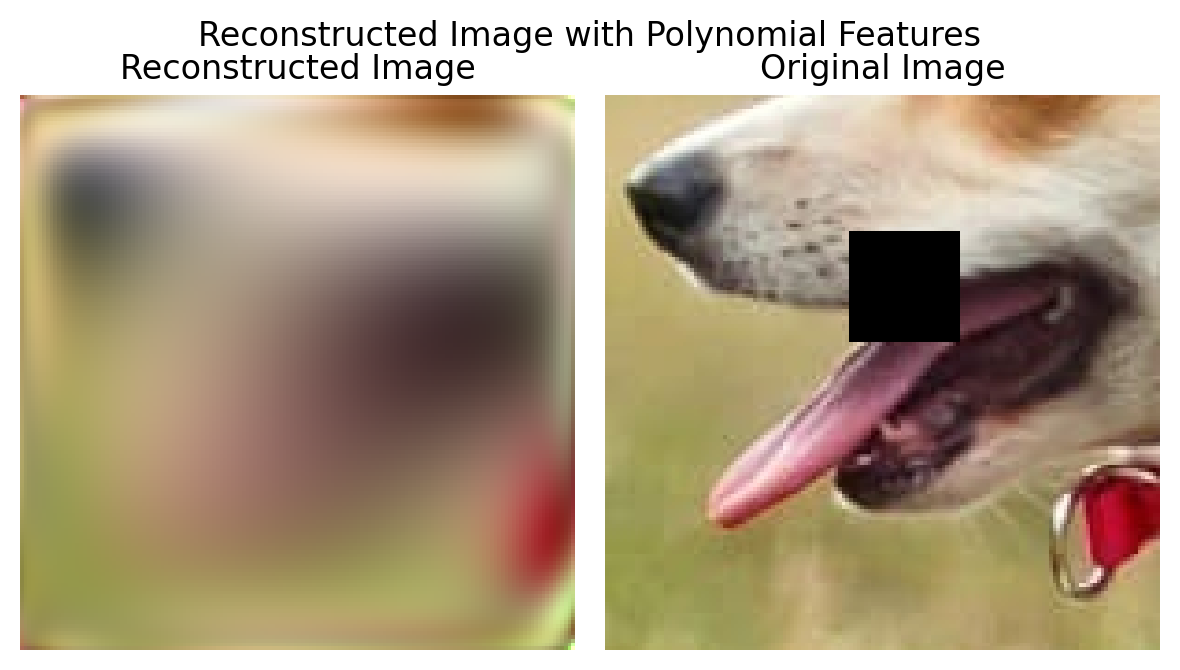

In [41]:
_,_ = plot_reconstructed_and_original_image(patch_img, net, scaled_X_poly, title="Reconstructed Image with Polynomial Features")

In [42]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [43]:
X_rff = create_rff_features(scaled_X, 37500, 0.008)

In [44]:
X_rff.shape

torch.Size([22500, 37500])

In [45]:
new_X_rff, new_Y_rff = removve_nans(X_rff,Y,X_rff.shape[1])

In [46]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, new_X_rff, new_Y_rff, 2500)

Epoch 0 loss: 0.340630
Epoch 100 loss: 0.034300
Epoch 200 loss: 0.008296
Epoch 300 loss: 0.003767
Epoch 400 loss: 0.001744
Epoch 500 loss: 0.000777
Epoch 600 loss: 0.000330
Epoch 700 loss: 0.000133
Epoch 800 loss: 0.000052
Epoch 900 loss: 0.000019
Epoch 1000 loss: 0.000008
Epoch 1100 loss: 0.000003
Epoch 1200 loss: 0.000002
Epoch 1300 loss: 0.000002
Epoch 1400 loss: 0.000001
Epoch 1500 loss: 0.000001
Epoch 1600 loss: 0.000001
Epoch 1700 loss: 0.000001
Epoch 1800 loss: 0.000001
Epoch 1900 loss: 0.000001
Epoch 2000 loss: 0.000001
Epoch 2100 loss: 0.000001
Epoch 2200 loss: 0.000001
Epoch 2300 loss: 0.000001
Epoch 2400 loss: 0.000001


9.870410622170311e-07

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


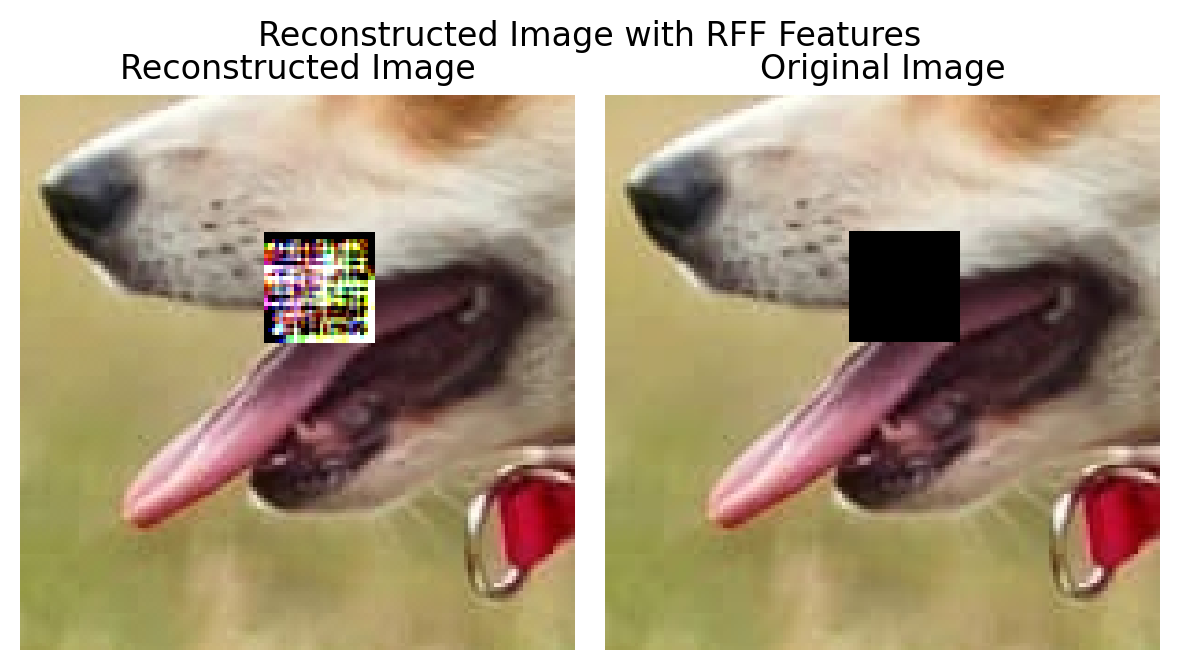

In [47]:
# patch_img_rmse_RFF = calculate_rmse(rearrange(crop,'c h w -> h w c'),reconstructed_img)
# patch_img_psnr_RFF = calculate_psnr(rearrange(crop,'c h w -> h w c'),reconstructed_img)
# print(f"RMSE: {patch_img_rmse_MF}")
# print(f"PSNR: {patch_img_rmse_PSNR} db")
patch_img_rmse_RFF,patch_img_psnr_RFF = plot_reconstructed_and_original_image(patch_img, net, X_rff, title="Reconstructed Image with RFF Features")

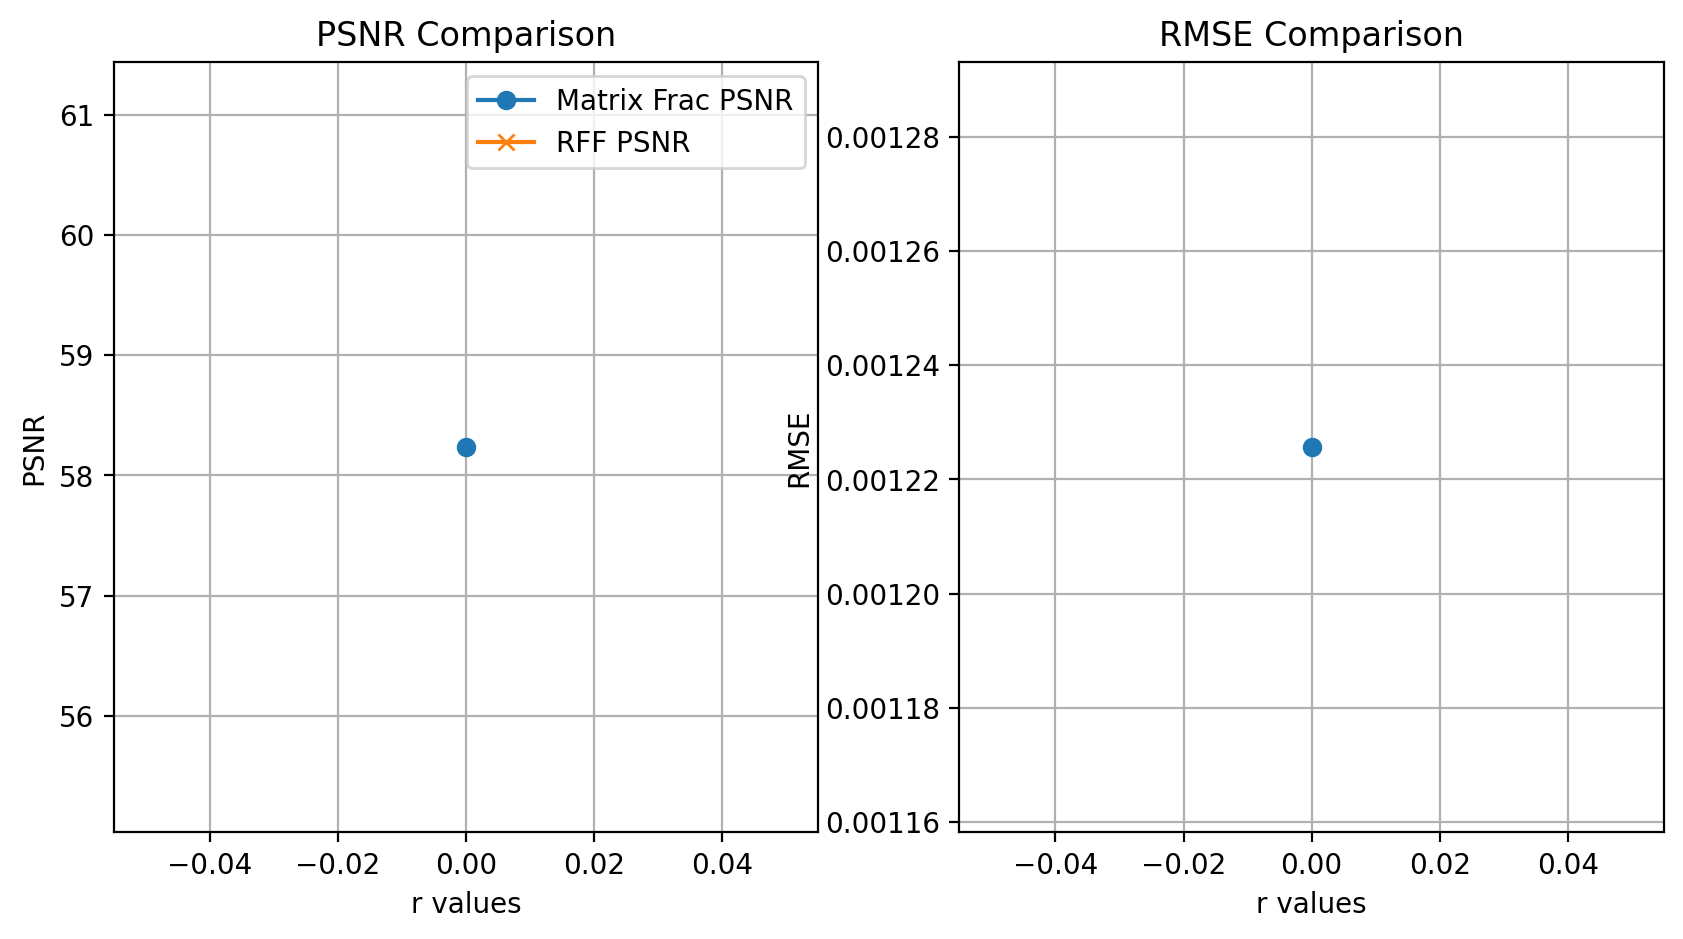

In [50]:
fig1, axs1, = plt.subplots(1, 2, figsize=(10, 5))
    # PSNR comparison

axs1[0].plot(patch_img_psnr_MF,label='Matrix Frac PSNR', marker='o')
axs1[0].plot(patch_img_psnr_RFF,label='RFF PSNR', marker='x')
axs1[0].set_xlabel('r values')
axs1[0].set_ylabel('PSNR')
axs1[0].set_title('PSNR Comparison')
axs1[0].legend()
axs1[0].grid()

# RMS comparison
axs1[1].plot(patch_img_rmse_MF.detach().cpu().numpy(), label='Matrix Frac RMS', marker='o')
axs1[1].plot(patch_img_rmse_RFF.detach().cpu().numpy(), label='WALS RMS', marker='x')
axs1[1].set_xlabel('r values')
axs1[1].set_ylabel('RMSE')
axs1[1].set_title('RMSE Comparison')
axs1[1].grid()

plt.show()